In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [41]:
"""
Adapted from https://github.com/lukemelas/simple-bert
"""
 
import numpy as np
from torch import nn
from torch import Tensor 
from torch.nn import functional as F

PEFT = 0

def split_last(x, shape):
    "split the last dimension to given shape"
    shape = list(shape)
    assert shape.count(-1) <= 1
    if -1 in shape:
        shape[shape.index(-1)] = int(x.size(-1) / -np.prod(shape))
    return x.view(*x.size()[:-1], *shape)


def merge_last(x, n_dims):
    "merge the last n_dims to a dimension"
    s = x.size()
    assert n_dims > 1 and n_dims < len(s)
    return x.view(*s[:-n_dims], -1)

class TrainableEltwiseLayer(nn.Module):
    def __init__(self, n, h, w):
        super(TrainableEltwiseLayer, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(1, n, h, w))  # define the trainable parameter

    def forward(self, x):
        # assuming x is of size b-1-h-w
        return x * self.weights  # element-wise multiplication


class MultiHeadedSelfAttention(nn.Module):
    """Multi-Headed Dot Product Attention"""
    def __init__(self, dim, num_heads, dropout):
        super().__init__()
        self.proj_q = nn.Linear(dim, dim)
        self.proj_k = nn.Linear(dim, dim)
        self.proj_v = nn.Linear(dim, dim)
        
        head_dim = dim // num_heads
        #PEFT
        if PEFT:
            self.lk = TrainableEltwiseLayer(num_heads, head_dim, 145)
            nn.init.ones_(self.lk.weights)
            self.lv = TrainableEltwiseLayer(num_heads, 145, head_dim)
            nn.init.ones_(self.lv.weights)

        self.drop = nn.Dropout(dropout)
        self.n_heads = num_heads
        self.scores = None # for visualization

    def forward(self, x, mask):
        """
        x, q(query), k(key), v(value) : (B(batch_size), S(seq_len), D(dim))
        mask : (B(batch_size) x S(seq_len))
        * split D(dim) into (H(n_heads), W(width of head)) ; D = H * W
        """
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q, k, v = self.proj_q(x), self.proj_k(x), self.proj_v(x)
        q, k, v = (split_last(x, (self.n_heads, -1)).transpose(1, 2) for x in [q, k, v])
        
        #PEFT
        if PEFT:
            k = self.lk(k.transpose(-2, -1))
            v = self.lv(v)
            scores = q @ k / np.sqrt(k.size(-1))
        else:
          # (B, H, S, W) @ (B, H, W, S) -> (B, H, S, S) -softmax-> (B, H, S, S)
          scores = q @ k.transpose(-2, -1) / np.sqrt(k.size(-1))
        if mask is not None:
            mask = mask[:, None, None, :].float()
            scores -= 10000.0 * (1.0 - mask)
        scores = self.drop(F.softmax(scores, dim=-1))
        # (B, H, S, S) @ (B, H, S, W) -> (B, H, S, W) -trans-> (B, S, H, W)
        h = (scores @ v).transpose(1, 2).contiguous()
        # -merge-> (B, S, D)
        h = merge_last(h, 2)
        self.scores = scores
        return h


class PositionWiseFeedForward(nn.Module):
    """FeedForward Neural Networks for each position"""
    def __init__(self, dim, ff_dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, ff_dim)
        #PEFT
        if PEFT:
            self.fcpeft = nn.Linear(ff_dim, ff_dim)
        
        self.fc2 = nn.Linear(ff_dim, dim)

    def forward(self, x):
        # (B, S, D) -> (B, S, D_ff) -> (B, S, D)
        if PEFT:
            return self.fc2(self.fcpeft(F.gelu(self.fc1(x))))
        return self.fc2(F.gelu(self.fc1(x)))


class Block(nn.Module):
    """Transformer Block"""
    def __init__(self, dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.attn = MultiHeadedSelfAttention(dim, num_heads, dropout)
        self.proj = nn.Linear(dim, dim)
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.pwff = PositionWiseFeedForward(dim, ff_dim)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, mask):
        h = self.drop(self.proj(self.attn(self.norm1(x), mask)))
        x = x + h
        h = self.drop(self.pwff(self.norm2(x)))
        x = x + h
        return x


class Transformer(nn.Module):
    """Transformer with Self-Attentive Blocks"""
    def __init__(self, num_layers, dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(dim, num_heads, ff_dim, dropout) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for block in self.blocks:
            x = block(x, mask)
        return x


In [44]:
"""model.py - Model and module class for ViT.
   They are built to mirror those in the official Jax implementation.
"""

from typing import Optional
import torch
from torch import nn
from torch.nn import functional as F

from pytorch_pretrained_vit.utils import load_pretrained_weights, as_tuple
from pytorch_pretrained_vit.configs import PRETRAINED_MODELS


class PositionalEmbedding1D(nn.Module):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, seq_len, dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, dim))
    
    def forward(self, x):
        """Input has shape `(batch_size, seq_len, emb_dim)`"""
        return x + self.pos_embedding


class ViT(nn.Module):
    """
    Args:
        name (str): Model name, e.g. 'B_16'
        pretrained (bool): Load pretrained weights
        in_channels (int): Number of channels in input data
        num_classes (int): Number of classes, default 1000

    References:
        [1] https://openreview.net/forum?id=YicbFdNTTy
    """

    def __init__(
        self, 
        name: Optional[str] = None, 
        pretrained: bool = False, 
        patches: int = 16,
        dim: int = 768,
        ff_dim: int = 3072,
        num_heads: int = 12,
        num_layers: int = 12,
        attention_dropout_rate: float = 0.0,
        dropout_rate: float = 0.1,
        representation_size: Optional[int] = None,
        load_repr_layer: bool = False,
        classifier: str = 'token',
        positional_embedding: str = '1d',
        in_channels: int = 3, 
        image_size: Optional[int] = None,
        num_classes: Optional[int] = None,
    ):
        super().__init__()

        # Configuration
        if name is None:
            check_msg = 'must specify name of pretrained model'
            assert not pretrained, check_msg
            #assert not resize_positional_embedding, check_msg
            if num_classes is None:
                num_classes = 1000
            if image_size is None:
                image_size = 384
        else:  # load pretrained model
            assert name in PRETRAINED_MODELS.keys(), \
                'name should be in: ' + ', '.join(PRETRAINED_MODELS.keys())
            config = PRETRAINED_MODELS[name]['config']
            patches = config['patches']
            dim = config['dim']
            ff_dim = config['ff_dim']
            num_heads = config['num_heads']
            num_layers = config['num_layers']
            attention_dropout_rate = config['attention_dropout_rate']
            dropout_rate = config['dropout_rate']
            representation_size = config['representation_size']
            classifier = config['classifier']
            if image_size is None:
                image_size = PRETRAINED_MODELS[name]['image_size']
            if num_classes is None:
                num_classes = PRETRAINED_MODELS[name]['num_classes']
        self.image_size = image_size                

        # Image and patch sizes
        h, w = as_tuple(image_size)  # image sizes
        fh, fw = as_tuple(patches)  # patch sizes
        gh, gw = h // fh, w // fw  # number of patches
        seq_len = gh * gw

        # Patch embedding
        self.patch_embedding = nn.Conv2d(in_channels, dim, kernel_size=(fh, fw), stride=(fh, fw))

        # Class token
        if classifier == 'token':
            self.class_token = nn.Parameter(torch.zeros(1, 1, dim))
            seq_len += 1
        
        # Positional embedding
        if positional_embedding.lower() == '1d':
            self.positional_embedding = PositionalEmbedding1D(seq_len, dim)
        else:
            raise NotImplementedError()
        
        # Transformer
        self.transformer = Transformer(num_layers=num_layers, dim=dim, num_heads=num_heads, 
                                       ff_dim=ff_dim, dropout=dropout_rate)
        
        # Representation layer
        if representation_size and load_repr_layer:
            self.pre_logits = nn.Linear(dim, representation_size)
            pre_logits_size = representation_size
        else:
            pre_logits_size = dim

        # Classifier head
        self.norm = nn.LayerNorm(pre_logits_size, eps=1e-6)
        self.fc = nn.Linear(pre_logits_size, num_classes)

        # Initialize weights
        self.init_weights()
        
        # Load pretrained model
        if pretrained:
            pretrained_num_channels = 3
            pretrained_num_classes = PRETRAINED_MODELS[name]['num_classes']
            pretrained_image_size = PRETRAINED_MODELS[name]['image_size']
            load_pretrained_weights(
                self, name, 
                load_first_conv=(in_channels == pretrained_num_channels),
                load_fc=(num_classes == pretrained_num_classes),
                load_repr_layer=load_repr_layer,
                strict=False,
                resize_positional_embedding=(image_size != pretrained_image_size),
            )
        
    @torch.no_grad()
    def init_weights(self):
        def _init(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # _trunc_normal(m.weight, std=0.02)  # from .initialization import _trunc_normal
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)  # nn.init.constant(m.bias, 0)
        self.apply(_init)
        nn.init.constant_(self.fc.weight, 0)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.normal_(self.positional_embedding.pos_embedding, std=0.02)  # _trunc_normal(self.positional_embedding.pos_embedding, std=0.02)
        nn.init.constant_(self.class_token, 0)

    def forward(self, x):
        """Breaks image into patches, applies transformer, applies MLP head.

        Args:
            x (tensor): `b,c,fh,fw`
        """
        b, c, fh, fw = x.shape
        x = self.patch_embedding(x)  # b,d,gh,gw
        x = x.flatten(2).transpose(1, 2)  # b,gh*gw,d
        if hasattr(self, 'class_token'):
            x = torch.cat((self.class_token.expand(b, -1, -1), x), dim=1)  # b,gh*gw+1,d
        if hasattr(self, 'positional_embedding'): 
            x = self.positional_embedding(x)  # b,gh*gw+1,d 
        x = self.transformer(x)  # b,gh*gw+1,d
        if hasattr(self, 'pre_logits'):
            x = self.pre_logits(x)
            x = torch.tanh(x)
        if hasattr(self, 'fc'):
            x = self.norm(x)[:, 0]  # b,d
            x = self.fc(x)  # b,num_classes
        return x



In [4]:
model = ViT('B_16', pretrained=True)

Loaded pretrained weights.


In [5]:
import torch
input_img = torch.rand(1, 3,224,224)
out = model(input_img)

In [6]:
out.shape

torch.Size([1, 21843])

In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [8]:
dataset = CIFAR10(root='data/', download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((384, 384))]))
test_dataset = CIFAR10(root='data/', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((384, 384))]))

Files already downloaded and verified


In [9]:
classes = dataset.classes
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [10]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [11]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [31]:
batch_size=32

In [34]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=20, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 384, 384])


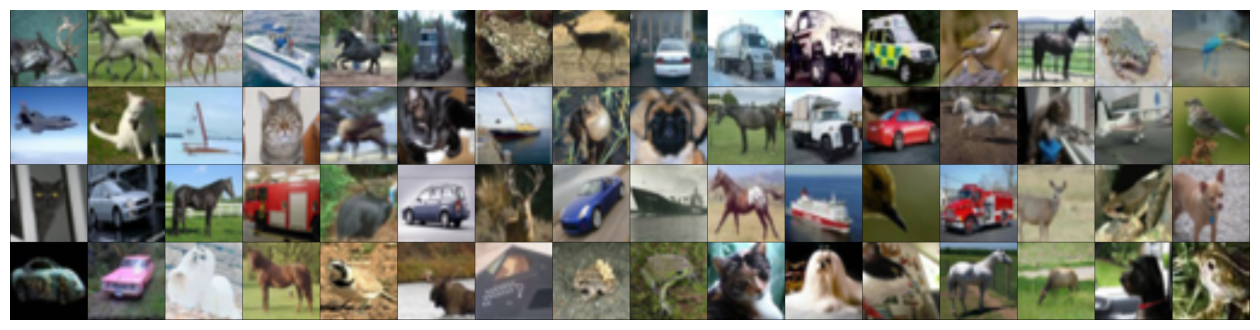

In [14]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        model.eval()
        images, labels = batch
        images = images.to(device=device, dtype=torch.float32)
        labels = labels.to(device=device, dtype=torch.long)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [17]:
import torch
def evaluate(model, val_loader):
    #outputs = [model.validation_step(batch) for batch in val_loader]
    outputs = []
    for batch in val_loader:
        model.eval()
        images, labels = batch
        images = images.to(device=device, dtype=torch.float32)
        labels = labels.to(device=device, dtype=torch.long)
        out = model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        outputs.append({'val_loss': loss.detach(), 'val_acc': acc})
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    model = torch.nn.DataParallel(model)
    model.to(device)
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            if n_gpu >=1 and not isinstance(model, torch.nn.DataParallel):
                model = torch.nn.DataParallel(model)
            model.to(device)
            model.train()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [21]:
n_gpu = torch.cuda.device_count()
n_gpu

10

In [22]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [25]:
# train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)
# test_loader = DeviceDataLoader(test_loader, device)

In [26]:
input_size = 3*384*384
output_size = 10

In [45]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
#         self.linear1 = nn.Linear(input_size, 256)
#         self.linear2 = nn.Linear(256, 128)
#         self.linear3 = nn.Linear(128, output_size)
        self.vit = ViT('B_32_imagenet1k', pretrained=True)
        self.linear1 = nn.Linear(1000,output_size)
        
    def forward(self, xb):
        out = self.vit(xb)
        out = F.relu(out)
        out = self.linear1(out)
        return out

In [51]:
PEFT = 0

model = CIFAR10Model()
model.to(device)

linear_probe = 1

if linear_probe:
    count = 0
    for name, param in model.named_parameters():
        if 'linear1' in name:
                param.requires_grad = True
                count += 1
        else:
              param.requires_grad = False
    print(count)

if PEFT:
    count = 0
    for name, param in model.named_parameters():
        if 'lk' in name or 'lv' in name or 'fcpeft' in name or 'linear1' in name:
            param.requires_grad = True
            count += 1
        else:
            param.requires_grad = False
    print(count)
history = [evaluate(model, val_loader)]
history

Missing keys when loading pretrained weights: []
Unexpected keys when loading pretrained weights: []
2


[{'val_loss': 2.3229408264160156, 'val_acc': 0.1385350376367569}]

In [52]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()

# device = torch.device('cpu')
# n_gpu = 0

print("Number of GPUs: "+str(n_gpu))

train_losses = []
n_epochs = 20

#weights = torch.FloatTensor([0.05,0.12,0.23,0.6]).to(device)

if n_gpu>=1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

results = []

import time
epoch_times = []

for epoch in range(n_epochs):
    start_time = time.time()
    if n_gpu >=1 and not isinstance(model, torch.nn.DataParallel):
        model = torch.nn.DataParallel(model)
    #model.to(device)
    model.train()
    
    train_loss = 0
    total_loss = 0
    batch_idx = 0
    for batch in train_loader:
        images, labels = batch 
        images = images.to(device=device, dtype=torch.float32)
        labels = labels.to(device=device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs.squeeze(),labels)
        
        if n_gpu>1:
            loss = loss.mean()
        
        train_loss = train_loss + ((1/(batch_idx+1))*(loss.item()-train_loss))
        total_loss = total_loss + loss.item()
        batch_idx += 1
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Training epoch: [{}/{}]; step loss:[{:.4f}]; cumulative train loss:[{:.4f}]'.format(epoch,n_epochs,loss.item(),train_loss))
    
    temp_res = evaluate(model, val_loader)
    results.append(temp_res)
    print(temp_res)
    scheduler.step()
    end_time = time.time()
    dur = end_time - start_time
    print('Time taken for the epoch '+str(dur))
    epoch_times.append(dur)

Number of GPUs: 10
Training epoch: [0/20]; step loss:[1.4895]; cumulative train loss:[1.7134]
Training epoch: [0/20]; step loss:[0.8796]; cumulative train loss:[1.4095]
Training epoch: [0/20]; step loss:[0.7200]; cumulative train loss:[1.2285]
Training epoch: [0/20]; step loss:[0.6361]; cumulative train loss:[1.1071]
Training epoch: [0/20]; step loss:[0.7908]; cumulative train loss:[1.0207]
Training epoch: [0/20]; step loss:[0.8620]; cumulative train loss:[0.9551]
Training epoch: [0/20]; step loss:[0.7753]; cumulative train loss:[0.9039]
Training epoch: [0/20]; step loss:[0.4377]; cumulative train loss:[0.8607]
Training epoch: [0/20]; step loss:[0.5922]; cumulative train loss:[0.8262]
Training epoch: [0/20]; step loss:[0.6033]; cumulative train loss:[0.7912]
Training epoch: [0/20]; step loss:[0.2993]; cumulative train loss:[0.7632]
Training epoch: [0/20]; step loss:[0.5664]; cumulative train loss:[0.7398]
Training epoch: [0/20]; step loss:[0.3392]; cumulative train loss:[0.7202]
Traini

Training epoch: [7/20]; step loss:[0.4128]; cumulative train loss:[0.3067]
Training epoch: [7/20]; step loss:[0.5330]; cumulative train loss:[0.3093]
Training epoch: [7/20]; step loss:[0.6236]; cumulative train loss:[0.3121]
Training epoch: [7/20]; step loss:[0.5171]; cumulative train loss:[0.3141]
Training epoch: [7/20]; step loss:[0.3348]; cumulative train loss:[0.3116]
Training epoch: [7/20]; step loss:[0.4995]; cumulative train loss:[0.3080]
Training epoch: [7/20]; step loss:[0.4126]; cumulative train loss:[0.3074]
Training epoch: [7/20]; step loss:[0.2892]; cumulative train loss:[0.3094]
Training epoch: [7/20]; step loss:[0.2278]; cumulative train loss:[0.3101]
Training epoch: [7/20]; step loss:[0.3091]; cumulative train loss:[0.3099]
Training epoch: [7/20]; step loss:[0.0732]; cumulative train loss:[0.3087]
Training epoch: [7/20]; step loss:[0.1940]; cumulative train loss:[0.3077]
{'val_loss': 0.29016345739364624, 'val_acc': 0.9108280539512634}
Time taken for the epoch 585.787802

KeyboardInterrupt: 

In [53]:
evaluate(model, test_loader)

{'val_loss': 0.28708553314208984, 'val_acc': 0.9084464907646179}

In [54]:
torch.save(model.state_dict(), 'vit_32_384_linear_probe.pth')

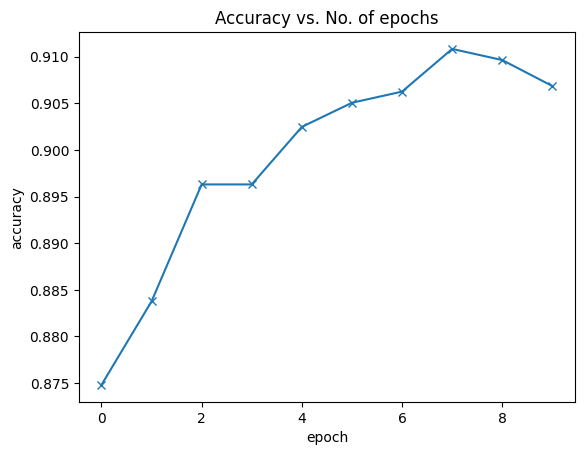

In [55]:
plot_accuracies(results)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
+